In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from PIL import Image

from random import randint

import matplotlib.pyplot as plt
import gc
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from tensorflow.python.keras.utils import conv_utils
#from keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape 
import tensorflow as tf

from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

/local_scratch/slurm.288613/ipykernel_3498191/1385814484.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
2024-07-15 11:37:59.250195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 11:37:59.272743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 11:37:59.272775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been re

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform_image=None, transform_mask=None):
        self.root_dir = root_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images_dir = os.path.join(root_dir, 'imgs')
        self.masks_dir = os.path.join(root_dir, 'masks')
        self.image_filenames = os.listdir(self.images_dir)
        
        self.image_filenames = [name for name in self.image_filenames if not name.startswith(".ipynb")]
        


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.masks_dir, self.image_filenames[idx].replace('img_', 'mask_').replace('.jpg', '.png'))
        
        

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('RGB')  # Convert to grayscale for single channel mask

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

In [3]:
# Transforms dataset
#transform = transforms.Compose([
#    transforms.Resize((256, 256)),  # Resize image
#    transforms.ToTensor(),
#])

# Define Transforms
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
# Defines dataset and dataloaders
train_dataset = CustomDataset(root_dir='CAVS/Main_Trail/Train', transform_image=transform_image, transform_mask=transform_mask)
test_dataset = CustomDataset(root_dir='CAVS/Main_Trail/Test', transform_image=transform_image, transform_mask=transform_mask)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
# Function to extract data from DataLoader
def extract_data_from_dataloader(dataloader):
    images_list = []
    masks_list = []
    
    for images, masks in tqdm(dataloader):
        images_list.append(images.numpy())  # Convert to numpy arrays
        masks_list.append(masks.numpy())    # Convert to numpy arrays
    
    # Stack the list of arrays into a single numpy array
    images_array = np.vstack(images_list)
    masks_array = np.vstack(masks_list)
    
    return images_array, masks_array

# Extract data from train and test dataloaders
train_images, train_masks = extract_data_from_dataloader(train_dataloader)
test_images, test_masks = extract_data_from_dataloader(test_dataloader)

# Assuming your masks are integer-encoded
#train_masks = to_categorical(train_masks, num_classes=3)
#test_masks = to_categorical(test_masks, num_classes=3)

# Create DataFrames
train_df = pd.DataFrame({'images': list(train_images), 'masks': list(train_masks)})
test_df = pd.DataFrame({'images': list(test_images), 'masks': list(test_masks)})


100%|██████████| 57/57 [00:01<00:00, 30.07it/s]


In [6]:
# Verify shapes of the data
print("train_images shape:", train_images.shape)
print("train_masks shape:", train_masks.shape)
print("test_images shape:", test_images.shape)
print("test_masks shape:", test_masks.shape)

train_images shape: (133, 3, 256, 256)
train_masks shape: (133, 3, 256, 256)
test_images shape: (57, 3, 256, 256)
test_masks shape: (57, 3, 256, 256)


In [7]:
# Create DataFrames
train_df = pd.DataFrame({'images': list(train_images), 'masks': list(train_masks)})
test_df = pd.DataFrame({'images': list(test_images), 'masks': list(test_masks)})
print("train_df shape:", train_images.shape)
print("test_df shape:", test_masks.shape)


train_df shape: (133, 3, 256, 256)
test_df shape: (57, 3, 256, 256)


In [8]:
img_size_ori = 960
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [9]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

TypeError: Invalid shape (3, 256, 256) for image data

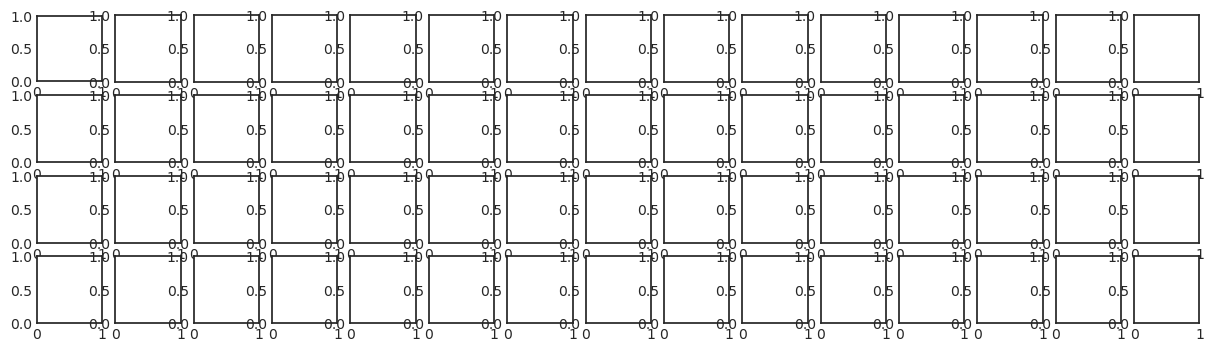

In [10]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    #ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [ ]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()), 
    np.array(train_df.masks.tolist()),
    train_df.coverage.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [ ]:
print(x_train.shape)
print(y_train.shape)

In [ ]:
#Build Model
# Define the conv_block_simple function
def conv_block_simple(inputs, filters, name):
    x = Conv2D(filters, (3, 3), padding='same', name=f'{name}_conv')(inputs)
    x = BatchNormalization(name=f'{name}_bn')(x)
    x = Activation('relu', name=f'{name}_act')(x)
    return x

def conv_block_simple_no_bn(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

In [ ]:
# Clear previous sessions
tf.keras.backend.clear_session()


In [ ]:
import warnings

from keras_applications.imagenet_utils import _obtain_input_shape
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras import backend as K
#from tensorflow.keras.engine import get_source_inputs
from tensorflow.python.keras.utils import layer_utils
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import categorical_crossentropy

WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [ ]:
def ResNet50_custom(input_shape=(256, 256, 3), num_classes=3):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    x = base_model.output
    x = Conv2D(2048, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)  # Upsample
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)  # Upsample
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)  # Upsample
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)  # Upsample
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)  # Upsample
    x = Conv2D(num_classes, (1, 1), activation='softmax')(x)  # Final layer for multi-class output

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [ ]:
def relu6(x):
    return K.relu(x, max_value=6)

In [ ]:
input_shape = (256, 256, 3)
model = ResNet50_custom(input_shape=input_shape, num_classes=3)
#model.summary()

In [ ]:
# Custom functions
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def generalized_dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def categorical_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + generalized_dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch], B[batch]        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10) / (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
    return np.mean(metric)

# Define the custom IOU metric function
def my_iou_metric(label, pred):
    return tf.py_function(func=get_iou_vector, inp=[label, tf.cast(pred > 0.5, tf.float32)], Tout=tf.float32)

In [ ]:
import gc
gc.enable()

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[my_iou_metric, 'accuracy'])

In [ ]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [ ]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")



In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical


model_checkpoint = ModelCheckpoint("./model.keras", monitor='val_my_iou_metric', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

# One-hot encode the masks
num_classes = 3
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)
# Verify shapes of the data
print("train_images shape:", train_images.shape)
print("train_masks shape:", train_masks.shape)
print("test_images shape:", test_images.shape)
print("test_masks shape:", test_masks.shape)

In [ ]:
epochs = 10
batch_size = 16

history = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid), 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr],
                    shuffle=True,
                    verbose=2)